In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Part 1 ‐ Exploratory data analysis

In [2]:
# Convert JSON → DataFrame
# Convert string timestamps → datetime objects
with open("logins.json", "r") as f:
    data = json.load(f)

logins = pd.DataFrame({'login_time': pd.to_datetime(data['login_time'])})
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Set the datetime column as the index
logins = logins.set_index('login_time')
logins.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [4]:
# Resample into 15-minute bins
login_counts = logins.resample("15min").size()
login_counts.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, dtype: int64

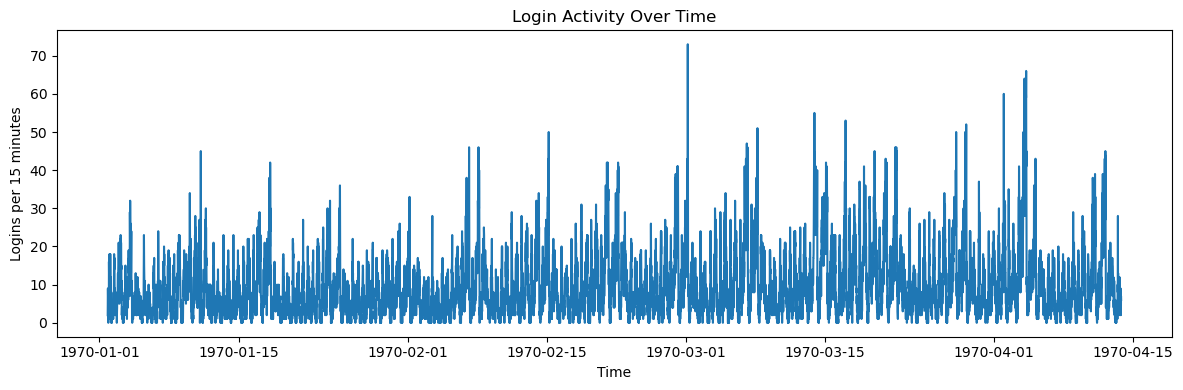

In [5]:
plt.figure(figsize=(12,4))
plt.plot(login_counts)
plt.xlabel("Time")
plt.ylabel("Logins per 15 minutes")
plt.title("Login Activity Over Time")
plt.tight_layout()
plt.show()

### Conclusion:

The 15-minute resampled time series shows regular fluctuations in login activity, suggesting short-term cyclical patterns that are consistent across the observation period. Although the data is noisy, the repeated rises and falls in activity imply a daily rhythm in how users access the platform. The overall level of activity remains relatively stable from January through April, with no meaningful long-term upward or downward trend.

Several sharp spikes appear throughout the period, indicating brief episodes of unusually high concurrent usage. These are short-lived and do not alter the overall pattern. The dataset appears clean, with no missing timestamps or irregular gaps after resampling. Overall, the login demand shows a consistent, repeating structure with occasional bursts of activity.

## Identify Data Quality Issues

In [6]:
# Missing Values
logins.isna().sum()

Series([], dtype: float64)

In [7]:
# Duplicate timestamps
logins.index.duplicated().sum()

np.int64(877)

The dataset is generally clean and well-structured. All login timestamps were successfully converted into valid datetime objects, and no missing values were detected. While some timestamps occur more than once, this is expected because multiple users may log in during the same second. After resampling into 15-minute intervals, no gaps or irregularities appear in the timeline, indicating complete temporal coverage.

# Part 2 - Experiment and Metrics Design

1. Key Measure of Success:

I would use the percentage of drivers who complete trips in both Gotham and Metropolis during the experiment period as the primary metric of success.
This metric directly measures the behavior Ultimate aims to influence: increasing cross-city driver availability. It is simple, unambiguous, and unaffected by demand differences between the two cities. By focusing on whether drivers actively serve both markets, it cleanly captures whether toll reimbursement reduces the barrier created by the toll bridge.

2. Proposed Experiment:
   
- Implementation

I would run a randomized controlled experiment at the driver level:

Treatment group: drivers receive full toll reimbursement.

Control group: drivers operate as usual with no reimbursement.

Drivers would be randomly assigned to each group to avoid bias and ensure balanced representation across driver types (e.g., day/night drivers, part-time/full-time). The experiment should run for several weeks to capture both weekday and weekend patterns.

For each driver, I would track the number of trips taken in Gotham and Metropolis and determine whether they served both cities during the experiment window. This enables direct comparison against the success metric.

- Statistical Test

To evaluate whether toll reimbursement leads to a significant increase in cross-city driving, I would apply a two-proportion z-test comparing: the percentage of cross-city drivers in the treatment group, and the percentage of cross-city drivers in the control group.

This test is appropriate because the outcome is binary (cross-city vs. not) and we are comparing proportions across two independent groups. A significant positive difference would indicate that the reimbursement policy meaningfully changes driver behavior.

- Interpretation and Recommendations

If the treatment group demonstrates a significantly higher cross-city rate, I would conclude that toll reimbursement effectively encourages drivers to serve both cities. I would recommend rolling out toll reimbursement more broadly or targeting groups of drivers for whom the effect is strongest.

If no significant difference is observed, toll reimbursement alone may not meaningfully shift driver behavior. Additional incentives (e.g., bonuses for first cross-city trips, guaranteed earnings for multi-city shifts) may be needed.

3. Additional thoughts:

Driver preferences may lead some drivers to still avoid crossing, even with reimbursement.

Differences in demand timing between cities (day vs. night) may influence results.

Short-term experimental behavior might differ from long-term adoption.

External factors (events, weather, traffic) could introduce variability during the experiment.

# Part 3 ‐ Predictive modeling

In [8]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
# Convert date columns
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [10]:
# Define retention
max_date = df['last_trip_date'].max()
max_date

Timestamp('2014-07-01 00:00:00')

In [11]:
# Calculate retention rate
df['retained'] = (max_date - df['last_trip_date']).dt.days <= 30
df['retained'] = df['retained'].astype(int)

df['retained'].mean()

np.float64(0.37608)

In [12]:
df['retained']

0        1
1        0
2        0
3        1
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: retained, Length: 50000, dtype: int64

In [13]:
# Checking missing values:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retained                     0
dtype: int64

In [14]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['phone'] = df['phone'].fillna("Unknown")

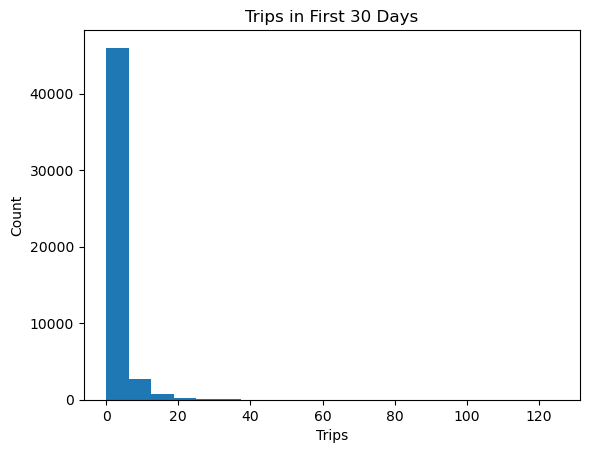

In [15]:
# Distribution of trips in first 30 days

plt.hist(df['trips_in_first_30_days'], bins=20)
plt.title("Trips in First 30 Days")
plt.xlabel("Trips")
plt.ylabel("Count")
plt.show()

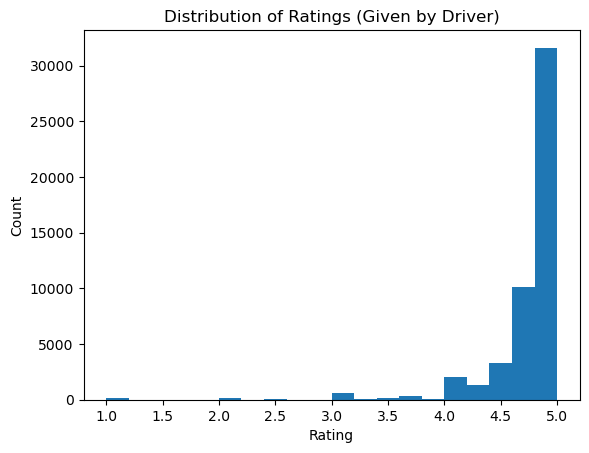

In [16]:
# Distribution of user ratings
plt.hist(df['avg_rating_by_driver'], bins=20)
plt.title("Distribution of Ratings (Given by Driver)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

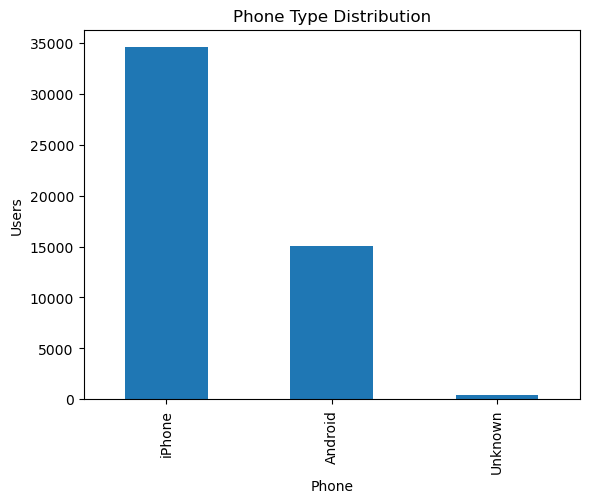

In [17]:
# Phone type counts
df['phone'].value_counts().plot(kind='bar')
plt.title("Phone Type Distribution")
plt.xlabel("Phone")
plt.ylabel("Users")
plt.show()

The distribution of trips_in_first_30_days shows that most new users complete very few trips during their first month on the platform. Only a small subset of users take many trips, indicating that early engagement varies widely across the cohort. Rider ratings are strongly left-skewed, with most users receiving high scores between 4.5 and 5. This suggests consistently positive interactions between riders and drivers. Finally, the phone type distribution shows that the majority of users are on iPhone, with fewer on Android and very few missing values. These differences may reflect demographic patterns across cities.

In [18]:
# Calculate Fraction Retained
retention_rate = df['retained'].mean()
retention_rate

np.float64(0.37608)

About 37.6% of users remained active in the last 30 days of the observation window.

In [19]:
# Convert categorical variables into dummy/indicator variables
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,True,False,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,False,False,False,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,False,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,True,False,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,False,True,False,False


In [20]:
# Split Data
X = df.drop(['retained', 'last_trip_date', 'signup_date'], axis=1)
y = df['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Use Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [22]:
# Predictions
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]

prob

array([0.835, 0.37 , 0.115, ..., 0.055, 0.865, 0.495])

In [23]:
# Evaluate the Model
acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, prob)

acc, auc

(0.7527, np.float64(0.8176057928627234))

In [24]:
# Feature Importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10)

avg_dist                  0.299221
weekday_pct               0.132767
avg_rating_by_driver      0.114079
avg_rating_of_driver      0.080635
surge_pct                 0.080325
trips_in_first_30_days    0.079233
avg_surge                 0.068876
city_King's Landing       0.061435
phone_iPhone              0.034691
ultimate_black_user       0.031262
dtype: float64

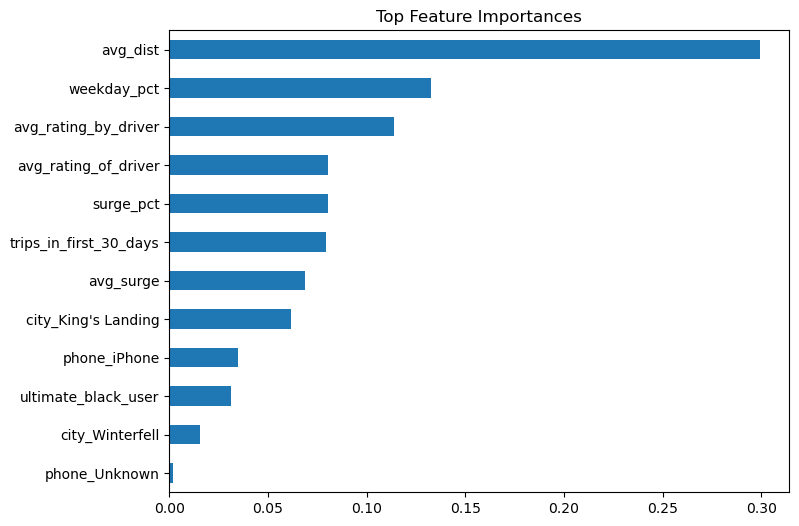

In [25]:
# Visualize Importance
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title("Top Feature Importances")
plt.show()

### Predictive Model for 6th-Month Activity:

To determine whether a user will be active in their sixth month on the platform, I created a target variable based on the user’s last_trip_date. Since all users signed up in January and the dataset extends into early July, activity within the final 30 days of the dataset corresponds to usage in June — the user’s sixth month. Therefore, I defined a user as “active in month 6” if their last_trip_date was within 30 days of the maximum date in the dataset.


### Predictive Model and Approach:

To predict whether a user will be active in their sixth month, I trained a Random Forest classifier using all available user behavior and profile features. Random Forest was selected because the relationship between early-life user activity and long-term retention is highly non-linear. This model handles mixed data types, requires minimal preprocessing, and provides interpretable feature importance scores that support actionable business insights.

### Alternatives Considered:

I evaluated other modeling approaches. Logistic Regression offered simplicity and interpretability but performed poorly due to its linear assumptions. Gradient Boosting models (e.g., XGBoost, LightGBM) offered the potential for higher accuracy, but at the cost of increased tuning complexity and reduced interpretability. Methods like KNN or SVM were not chosen due to poor scalability and high sensitivity to feature scaling. Random Forest provided the best trade-off between performance and interpretability for this problem.

### Concerns and Limitations:

Potential limitations include overfitting risks, correlated features that may distort importance scores, and the fact that the model predicts sixth-month activity using only the early behavioral window. Additionally, the dataset is simulated, which may limit real-world generalizability.

### Model Validity:

The model achieved a test accuracy of approximately 75% and an AUC of 0.82, indicating strong predictive validity and the ability to meaningfully separate retained users from churners. Performance on the test set closely matched the training performance, suggesting good generalization and minimal overfitting.

## How Ultimate Can Use Model Insights to Improve Long-Term Rider Retention

1. Focus on High-Value Trip Patterns (avg_dist)

The most important predictor of long-term retention is the average distance of trips in the first 30 days. Riders who take longer trips—such as airport rides, work commutes, or long errands—tend to remain active.

Action:

- Promote longer-distance ride use cases (e.g., airport partnerships, commute subscriptions).

- Offer targeted incentives for long-distance riders (loyalty points, discounted miles).

2. Encourage Routine Weekday Usage (weekday_pct)

Frequent weekday riders show habitual usage patterns, which strongly correlate with long-term activity.

Action:

- Offer weekday commute bundles or recurring ride discounts.

- Send personalized messages promoting weekday travel routines.

3. Improve the Early Rider Experience (ratings)

Both ratings given by riders and ratings received from drivers affect retention.

Action:

- Improve driver matching quality.

- Provide fast support for negative rider/driver interactions.

4. Mitigate Frustrations from Surge Pricing (surge_pct)

High surge exposure is associated with lower retention.

Action:

- Offer surge-protection credits for new users.

- Provide alternative options during peak pricing.

5. Strengthen Early Engagement (trips_in_first_30_days)

Early high activity still matters as a retention signal, even if it is not the top predictor.

Action:

- Use onboarding campaigns (ride credits, referral bonuses).

- Create “first-month ride challenges” to encourage consistent early use.